In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
data_plot = pd.read_csv('./TN-regplot_fit_data.csv')
data_exog = sm.add_constant(data_plot['LS'])

In [38]:
data_exog

,const,pm_unc
0,1.0,0.160377
1,1.0,0.161554
2,1.0,0.164200
3,1.0,0.164007
4,1.0,0.168393
...,...,...
102,1.0,0.163150
103,1.0,0.162662
104,1.0,0.178881
105,1.0,0.168090


In [39]:
rlm_model = sm.RLM(data_plot['pm_unc'],data_exog , M=sm.robust.norms.HuberT())

In [40]:
res= rlm_model.fit()

In [41]:
res.params

const     1.068587
pm_unc   -4.000236
dtype: float64

In [42]:
rlm_model.weights

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.90239244, 1.        , 1.        , 1.        ,
       0.89506087, 1.        , 1.        , 1.        , 0.8599444 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.38096162, 1.        , 0.70564621, 1.        ,
       0.48453848, 0.61792151, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.09537385, 0.68975088,
       1.        , 1.        , 0.19101401, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.25402657,
       1.        , 1.        , 1.        , 0.88498268, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.91678037, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

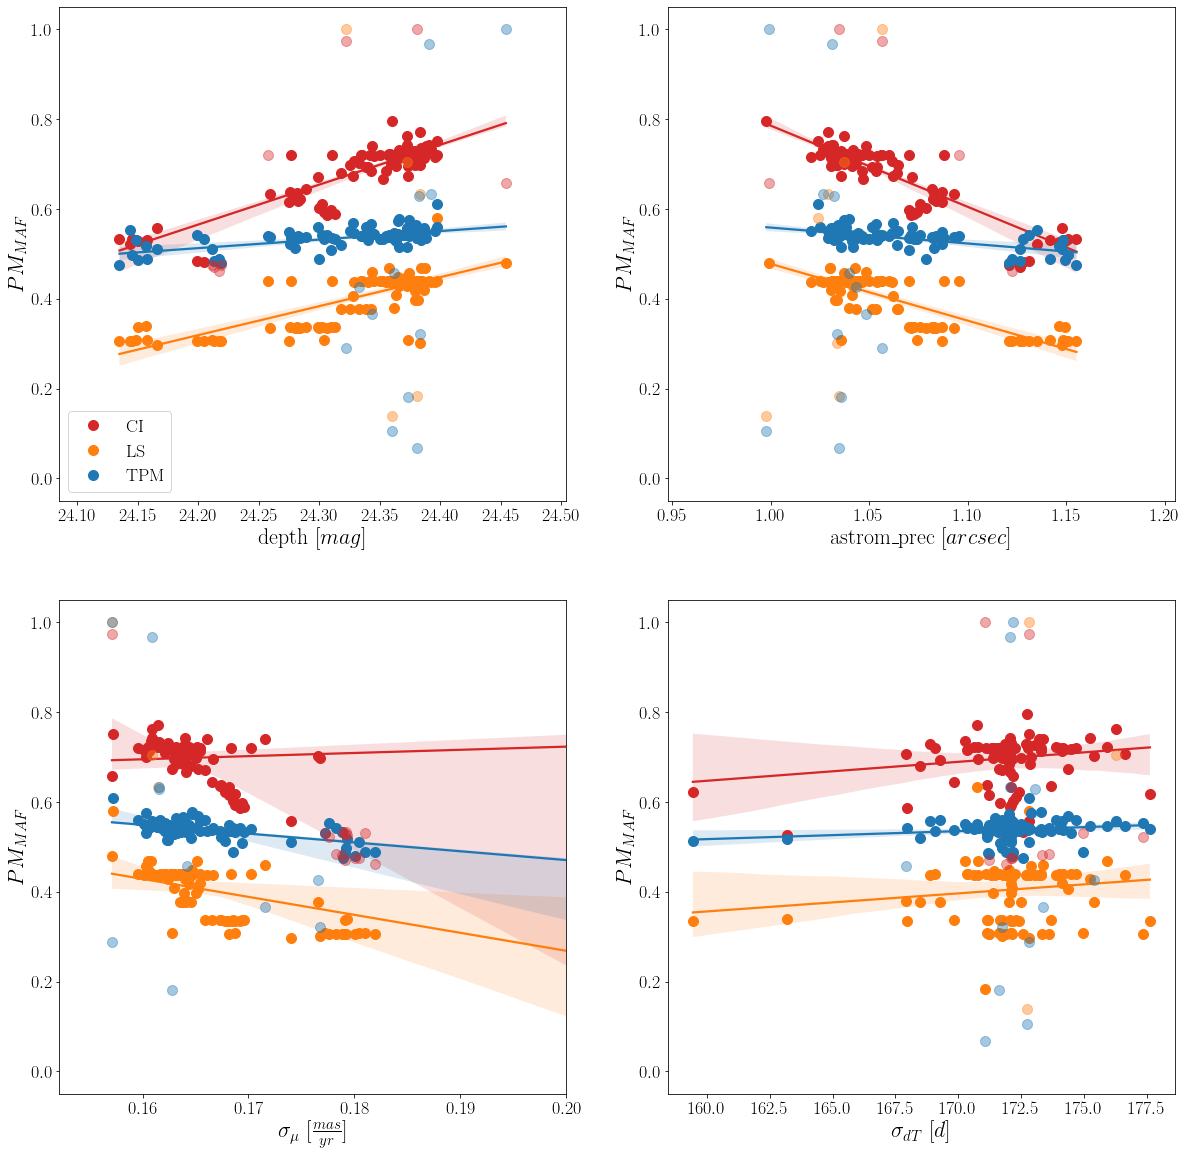

In [3]:
import matplotlib
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = "10"
cm = plt.get_cmap('tab10')
params = {}
colors = np.array( [cm.colors[3],cm.colors[1],cm.colors[0]])
fig, axs = plt.subplots(2,2,figsize=(20,20))
for i,(ax, sysm, unit) in enumerate(zip(axs.flatten(),['depth', 'astrom_prec', 'pm_unc', 'sigma_dT'],
                                  [r' $[ mag]$',r' $[arcsec]$',r' $[\frac{mas}{yr}]$',r' $[ d]$'])):
    params[sysm]  = pd.DataFrame(index = ['CI','LS','TPM'], columns = ['intercept','intercept_err' ,'slope', 'slope_err'])
    for j, (metric,color) in enumerate(zip(['CI','LS','TPM'],colors)):
            x_fit = sm.add_constant(data_plot[sysm])
            fit_model = sm.RLM(data_plot[metric],x_fit , M=sm.robust.norms.HuberT())
            fit_res = fit_model.fit()
            fit_mask = fit_model.weights
            X,Y = np.array(data_plot[sysm]), np.array(data_plot[metric])
            plot = pd.DataFrame({sysm:X, metric:Y})
            params[sysm]['slope'].iloc[j], params[sysm]['intercept'].iloc[j]= fit_model.fit().params
            params[sysm]['slope_err'].iloc[j], params[sysm]['intercept_err'].iloc[j]= fit_model.fit().bse
            sns.regplot(x=sysm, y=metric, data=plot,robust=True,ax = ax, color=color, marker='')
            ax.plot(np.array(data_plot[sysm])[np.where(fit_mask>0.3)], np.array(data_plot[metric])[np.where(fit_mask>0.3)],
                    marker='o',markersize= 10 ,ls='', color=color,label=metric)
            ax.plot(np.array(data_plot[sysm])[np.where(fit_mask<=0.3)], np.array(data_plot[metric])[np.where(fit_mask<=0.3)],
                    marker='o',markersize= 10 ,ls='', color=color, alpha=0.4,zorder=100)
    ax.set_ylabel(r'$PM_{MAF}$', fontsize=22) 
    ax.tick_params(axis='both', labelsize=18)
    if sysm =='sigma_dT':
        ax.set_xlabel(r'$\sigma_{dT}$'+unit , fontsize=22)
    elif sysm =='pm_unc':
        ax.set_xlabel(r'$\sigma_{\mu}$'+unit , fontsize=22)
    else:
        ax.set_xlabel(sysm+unit , fontsize=22)
    if sysm == 'pm_unc':
        ax.set_ylim([-0.05,1.05])
        ax.set_xlim([X.min()-0.005,0.2])
    elif sysm == 'sigma_dT':
        ax.set_ylim([-0.05,1.05])
        ax.set_xlim([data_plot[sysm].min()-1,data_plot[sysm].max()+1])
    else:
        ax.set_ylim([-0.05,1.05])
        ax.set_xlim([data_plot[sysm].min()-0.05,data_plot[sysm].max()+0.05])
    if i ==0:
        ax.legend(loc = 3, fontsize=18)
plt.savefig('./FoM-sysperf.pdf')

In [6]:
params

{'depth':     intercept intercept_err      slope slope_err
 CI   0.887621      0.035171 -20.915392  0.855707
 LS   0.644471      0.049759 -15.277282  1.210637
 TPM  0.189863       0.02683  -4.082095   0.65276,
 'astrom_prec':     intercept intercept_err     slope slope_err
 CI  -1.808543      0.073962  2.593895  0.078353
 LS  -1.264107       0.09311  1.741704  0.098638
 TPM -0.354753       0.05247    0.9131  0.055585,
 'pm_unc':     intercept intercept_err     slope slope_err
 CI   0.704296      0.199507  0.582111  0.034091
 LS  -4.000236       0.17768  1.068587  0.030362
 TPM -1.962149      0.074642  0.862876  0.012755,
 'sigma_dT':     intercept intercept_err     slope slope_err
 CI   0.004217      0.002079 -0.027785  0.357628
 LS   0.004016      0.002837  -0.28636  0.488049
 TPM  0.001777      0.000917  0.232759  0.157778}

In [7]:
params

{'depth':     intercept intercept_err      slope slope_err
 CI   0.681218      0.030036  23.873339   0.02061
 LS   0.524394      0.039005   24.12686  0.016274
 TPM  0.081558      0.049181  24.299096   0.02647,
 'astrom_prec':     intercept intercept_err     slope slope_err
 CI  -0.376391      0.015132  1.311595  0.010383
 LS  -0.268616      0.020844  1.163214  0.008696
 TPM -0.029822      0.026523  1.068722  0.014275,
 'pm_unc':     intercept intercept_err     slope slope_err
 CI  -0.065104      0.002405  0.209772   0.00165
 LS   -0.06553      0.003527  0.192134  0.001472
 TPM -0.047548       0.00415   0.19093  0.002234,
 'sigma_dT':     intercept intercept_err       slope slope_err
 CI  -0.104799      1.451774  172.162156  0.996164
 LS   1.191453      1.341986  171.607983  0.559902
 TPM  0.380192      1.236134  171.893162  0.665317}